In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import minimize_scalar, minimize
from scipy import sparse as sp
from time import time
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')
import cvxpy as cvx

# Simple example, $K=3$

In [158]:
np.random.seed(42)
t = np.linspace(0, 1000, 1000)
signal1 = np.sin(2 * np.pi * t * 1 / (500.))
signal2 = signal.square(2 * np.pi * t * 1 / (450.))
y = signal1 + signal2 + 0.25 * np.random.randn(len(signal1))

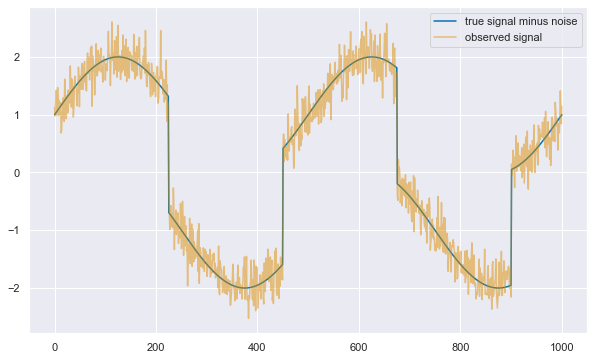

In [159]:
plt.figure(figsize=(10, 6))
plt.plot(t, signal1 + signal2, label='true signal minus noise')
plt.plot(t, y, alpha=0.5, label='observed signal')
plt.legend()
plt.show()

# A) Standard fomulation

In [162]:
n = len(y)
# use_ixs = np.ones(n, dtype=bool)
use_ixs = np.random.uniform(size=n) >= 0.2
# Variables
x1 = cvx.Variable(n)
x2 = cvx.Variable(n)
x3 = cvx.Variable(n)
# Parameters
theta1 = cvx.Parameter(nonneg=True, value=1)
theta2 = cvx.Parameter(nonneg=True, value=1e7)  # BIG!!
theta3 = cvx.Parameter(nonneg=True, value=1e1)
Mval = np.eye(n)
Mval = Mval[use_ixs]
###################
Mval = sp.coo_matrix(Mval)
Mnnz = cvx.Parameter(Mval.nnz, nonneg=True)
data = np.ones(Mnnz.size)
rows = Mval.row * n + Mval.col
cols = np.arange(Mnnz.size)
m = np.sum(use_ixs)
Indexer = sp.coo_matrix(
    (data, (rows, cols)), shape=(m * n, Mnnz.size))
M = cvx.reshape(Indexer @ Mnnz, (m, n), order='C')
Mnnz.value = Mval.data
###################
# M = cvx.Parameter(Mval.shape, nonneg=True, value=Mval)
###################
# Costs
phi1 = theta1 * cvx.sum_squares(x1)
phi2 = theta2 * cvx.sum_squares(cvx.diff(x2, k=2))
phi3 = theta3 * cvx.sum(cvx.abs(cvx.diff(x3, k=1)))
# Class constraints
constraints = [x3 >= -1, x3 <= 1]
# Global constraint
# constraints.append(M @ y == M @ (x1 + x2 + x3))
constraints.append(y[use_ixs] == (x1 + x2 + x3)[use_ixs])
# constraints.append(y == x1 + x2 + x3)
# Make problem
problem = cvx.Problem(cvx.Minimize(phi1 + phi2 + phi3), constraints)

### SCS problem data

Note the very large range on `c`.

In [163]:
ti = time()
data = problem.get_problem_data(cvx.SCS)[0]
tf = time()
print('{:.2f} seconds'.format(tf - ti))
A, b, c = data['A'], data['b'], data['c']
print(A.max(), A.min())
print(b.max(), b.min())
print(c.max(), c.min())

(804, 1000)
(804, 1000)
17.23 seconds
4.0 -2.0
2.348096555053405 -2.6046748078847575
10000000.0 0.0


In [46]:
Mval = np.eye(n)
Mval = Mval[use_ixs]
Mval = sp.coo_matrix(Mval)

In [47]:
np.allclose(Mval @ y, y[use_ixs])

True

### Solve with MOSEK

MOSEK is able to solve the problem (because of their auto-rescaling subroutines)

In [9]:
problem.solve(solver='MOSEK')

261.29221536690466

prob value: 2.61e+02


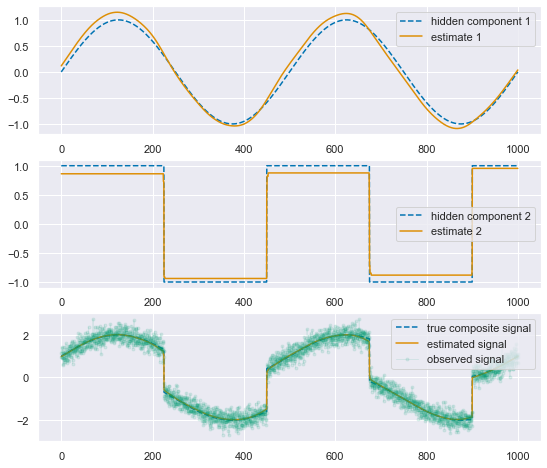

In [10]:
print('prob value: {:.2e}'.format(problem.value))
fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, x2.value, label='estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, x3.value, label='estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, x2.value + x3.value, label='estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()

### Attempt to solve with SCS

SCS is unable to solve the problem in it's current form.

In [11]:
problem.solve(solver='SCS', acceleration_lookback=0, max_iters=int(3e4))

/Users/bennetmeyers/miniconda3/envs/layers/lib/python3.7/site-packages/cvxpy/problems/problem.py:1126: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


4808.367973053883

prob value: 4.81e+03


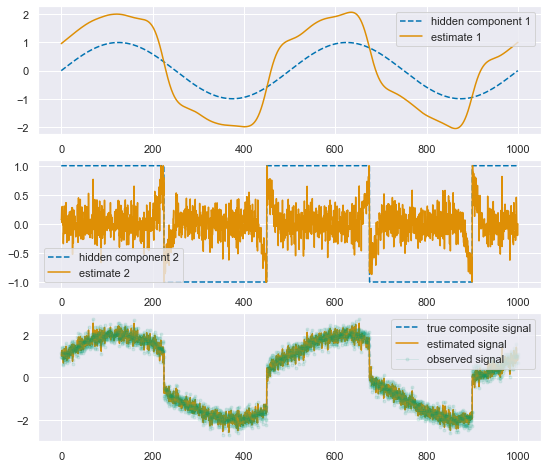

In [12]:
print('prob value: {:.2e}'.format(problem.value))
fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, x2.value, label='estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, x3.value, label='estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, x2.value + x3.value, label='estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()

# B) Rescaled problem

First option, diffuse weight into norm.

In [13]:
n = len(y)
use_ixs = np.ones(n, dtype=bool)
# Variables
x1 = cvx.Variable(n)
x2 = cvx.Variable(n)
x3 = cvx.Variable(n)
# Parameters
theta1 = cvx.Parameter(nonneg=True, value=1)
theta2 = cvx.Parameter(nonneg=True, value=10 ** (7/3))  # less big
theta3 = cvx.Parameter(nonneg=True, value=1e1)
M = np.eye(n)
M = M[use_ixs]
M = cvx.Parameter(M.shape, nonneg=True, value=M)
# Costs
phi1 = theta1 * cvx.sum_squares(x1)
phi2 = theta2 * cvx.sum_squares(10 ** (7/3) * cvx.diff(x2, k=2))  # diffused to here
phi3 = theta3 * cvx.sum(cvx.abs(cvx.diff(x3, k=1)))
# Class constraints
constraints = [x3 >= -1, x3 <= 1]
# Global constraint
# constraints.append(M @ y == M @ (x1 + x2 + x3))
constraints.append(y == x1 + x2 + x3)
# Make problem
problem = cvx.Problem(cvx.Minimize(phi1 + phi2 + phi3), constraints)

### SCS problem data

Note that `A` now has a larger range, but that all the data are less spread out than `c` was before.

In [14]:
data = problem.get_problem_data(cvx.SCS)[0]
A, b, c = data['A'], data['b'], data['c']
print(A.max(), A.min())
print(b.max(), b.min())
print(c.max(), c.min())

861.7738760127538 -430.8869380063769
2.7312063104947377 -2.7191680211318925
215.44346900318845 0.0


### Solve with MOSEK

Confirming that we are solving an equivalent problem and get the same answer.

In [15]:
problem.solve(solver='MOSEK')

261.2930893543471

prob value: 2.61e+02


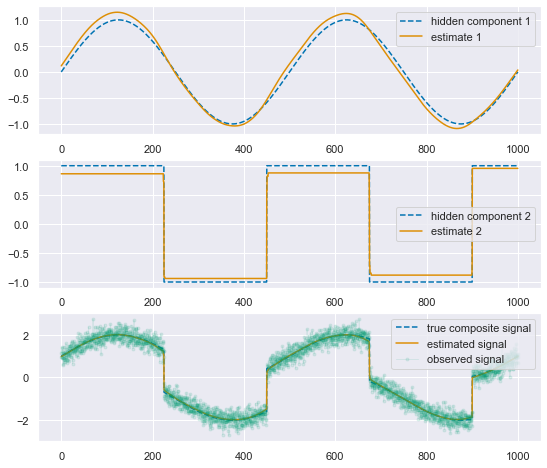

In [16]:
print('prob value: {:.2e}'.format(problem.value))
fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, x2.value, label='estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, x3.value, label='estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, x2.value + x3.value, label='estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()

### Solve with SCS

Now SCS finds nearly the same objective value as MOSEK, and a solution that appears almost identical.

In [17]:
problem.solve(solver='SCS', acceleration_lookback=0, max_iters=int(3e4))

261.3589215830367

prob value: 2.61e+02


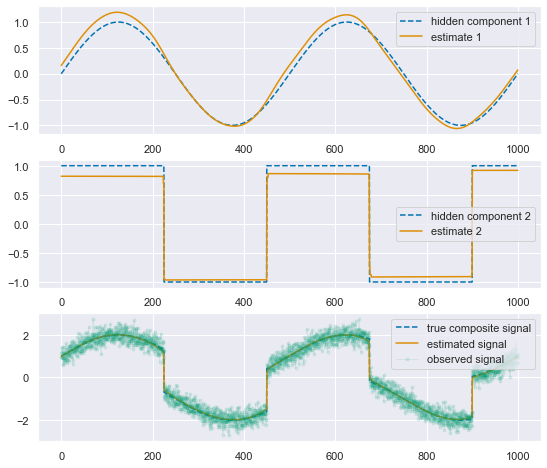

In [18]:
print('prob value: {:.2e}'.format(problem.value))
fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, x2.value, label='estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, x3.value, label='estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, x2.value + x3.value, label='estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()

# C) Rescaled problem

Second option, diffuse weight through variable substitution.

In [19]:
n = len(y)
use_ixs = np.ones(n, dtype=bool)
# Variables
x1 = cvx.Variable(n)
x2 = cvx.Variable(n)
x3 = cvx.Variable(n)
# Parameters
theta1 = cvx.Parameter(nonneg=True, value=1)
theta2 = cvx.Parameter(nonneg=True, value=1e7)  # BIG!!
theta2a = cvx.Parameter(nonneg=True, value=(1e7) ** (1/2))
theta2b = cvx.Parameter(nonneg=True, value=(1e7) ** (-1/2))
theta3 = cvx.Parameter(nonneg=True, value=1e1)
M = np.eye(n)
M = M[use_ixs]
M = cvx.Parameter(M.shape, nonneg=True, value=M)
# Costs
phi1 = theta1 * cvx.sum_squares(x1)
phi2 = cvx.sum_squares(cvx.diff(x2, k=2))
f = cvx.Variable()
phi3 = theta3 * cvx.sum(cvx.abs(cvx.diff(x3, k=1)))
# Class constraints
constraints = [x3 >= -1, x3 <= 1, theta2b * f >= theta2a * phi2]
# Global constraint
# constraints.append(M @ y == M @ (x1 + x2 + x3))
constraints.append(y == x1 + x2 + x3)
# Make problem
problem = cvx.Problem(cvx.Minimize(phi1 + f + phi3), constraints)

### SCS problem data

Note that `A` now has a larger range, but that all the data are less spread out than `c` was before.

In [20]:
data = problem.get_problem_data(cvx.SCS)[0]
A, b, c = data['A'], data['b'], data['c']
print(A.max(), A.min())
print(b.max(), b.min())
print(c.max(), c.min())

3162.2776601683795 -2.0
2.7312063104947377 -2.7191680211318925
10.0 0.0


### Solve with MOSEK

Confirming that we are solving an equivalent problem and get the same answer.

In [21]:
problem.solve(solver='MOSEK')

261.2922152802348

prob value: 2.61e+02


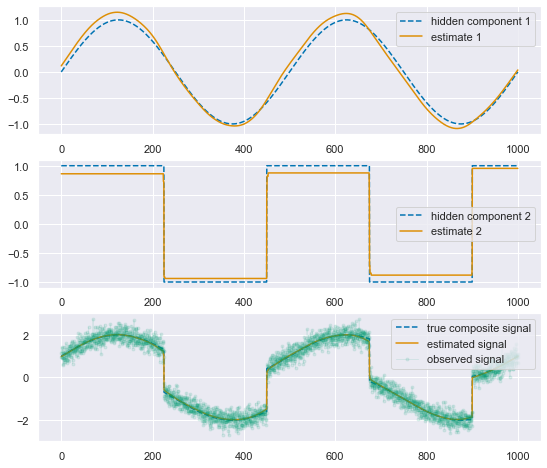

In [22]:
print('prob value: {:.2e}'.format(problem.value))
fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5))
ax[0].plot(t, signal1, label='hidden component 1', ls='--')
ax[0].plot(t, x2.value, label='estimate 1')
ax[1].plot(t, signal2, label='hidden component 2', ls='--')
ax[1].plot(t, x3.value, label='estimate 2')
ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
ax[2].plot(t, x2.value + x3.value, label='estimated signal');
ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
for a in ax:
    a.legend()

### Solve with SCS

SCS doesn't like this formulation and returns infeasible.

In [23]:
problem.solve(solver='SCS', acceleration_lookback=0, max_iters=int(3e4), verbose=True)

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 44994
eps = 1.00e-04, alpha = 1.50, max_iters = 30000, normalize = 1, scale = 1.00
acceleration_lookback = 0, rho_x = 1.00e-03
Variables n = 12002, constraints m = 21001
Cones:	primal zero / dual free vars: 3000
	linear vars: 11999
	soc vars: 6002, soc blks: 2
Setup time: 1.82e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 8.21e+19  4.09e+22  1.00e+00 -2.42e+28  9.97e+23  1.82e+28  7.19e-03 
    20| 1.51e+19  6.58e+19  1.00e+00 -1.13e+28  3.00e+23  1.13e+28  2.27e-02 
-----------------------------------------------------

-inf

In [27]:
print('prob value: {:.2e}'.format(problem.value))
try:
    fig, ax = plt.subplots(nrows=3, figsize=(10//1.1, 12//1.5))
    ax[0].plot(t, signal1, label='hidden component 1', ls='--')
    ax[0].plot(t, x2.value, label='estimate 1')
    ax[1].plot(t, signal2, label='hidden component 2', ls='--')
    ax[1].plot(t, x3.value, label='estimate 2')
    ax[2].plot(t, signal1 + signal2, label='true composite signal', ls='--')
    ax[2].plot(t, x2.value + x3.value, label='estimated signal');
    ax[2].plot(t, y, label='observed signal', linewidth=1, marker='.', alpha=0.1);
    for a in ax:
        a.legend()
except:
    plt.close(plt.gcf())

prob value: -inf
